# Will a Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaraunt near where you are driving. Would you accept that coupon and take a short detour to the restaraunt? Would you accept the coupon but use it on a sunbsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaraunt? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \\$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\\$20 - \\$50). 

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece. 





## Data Description

_Keep in mind that these values mentioned below are average values._

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)


3. Coupon attributes
    - time before it expires: 2 hours or one day

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Problems

Use the prompts below to get started with your data analysis.  

### Read in the `coupons.csv` file.

In [2]:
data = pd.read_csv('data/coupons.csv')

In [3]:
data.head(2)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0


### Investigate the dataset for missing or problematic data.

In [4]:
print('Dimensions of data read in (rows x columns): {}'.format(data.shape))

Dimensions of data read in (rows x columns): (12684, 26)


**%Completeness of each column - is there any missing data?**

In [5]:
data.isnull().sum().transform(lambda x: (1 - (x / data.shape[0])) * 100).round(2)

destination             100.00
passanger               100.00
weather                 100.00
temperature             100.00
time                    100.00
coupon                  100.00
expiration              100.00
gender                  100.00
age                     100.00
maritalStatus           100.00
has_children            100.00
education               100.00
occupation              100.00
income                  100.00
car                       0.85
Bar                      99.16
CoffeeHouse              98.29
CarryAway                98.81
RestaurantLessThan20     98.98
Restaurant20To50         98.51
toCoupon_GEQ5min        100.00
toCoupon_GEQ15min       100.00
toCoupon_GEQ25min       100.00
direction_same          100.00
direction_opp           100.00
Y                       100.00
dtype: float64

### Decide what to do about your missing data -- drop, replace, other...

* Drop car column: only 0.85% rows have values
* Keep the rest of the columns at this time - on average 98% rows have non-null data
    * Will decide later as we answer specific questions what to do about incomplete rows

In [6]:
car_nulls = data.car.isnull().sum()
data = data.drop(labels=('car'), axis=1)
print('Dropped column \'car\' since {} of {} rows are null - only {:.2f}% useful rows!'
      .format(car_nulls, data.shape[0], (1 - (car_nulls / data.shape[0])) * 100)
)

Dropped column 'car' since 12576 of 12684 rows are null - only 0.85% useful rows!


### What proportion of the total observations chose to accept the coupon? 

**Strategy**

* Data Prep:
    * Create new dataframe using Groupby Y and pull out the Y column
    * Grab the value_counts()
    * Add a new column 'Responses' and convert Y=(0,1) -> Responses=('Rejected','Accepted') for labels
* Visualization: Pie chart
    * Generate and prettify graph


In [7]:
# Prep data for Pie chart
acceptance_rate_pie = data.groupby('Y')['Y'].value_counts().rename('Responses').reset_index()

# Calculate overall acceptance rate
nayes = acceptance_rate_pie.iloc[0, 1]
ayes = acceptance_rate_pie.iloc[1, 1]
acceptance_rate = (ayes / data.shape[0]) * 100

print('Overall Coupon Acceptance Rate: {:.2f}%'
      .format(acceptance_rate))
print('{} accepted and {} did not from a total of {} responses'
      .format(ayes, nayes, data.shape[0]))

#acceptance_rate_pie

Overall Coupon Acceptance Rate: 56.84%
7210 accepted and 5474 did not from a total of 12684 responses


Text(0.5, 1.0, 'Overall Coupon Acceptance Rate')

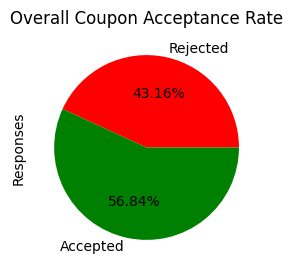

In [8]:
names = ('Rejected', 'Accepted')
colors = ('red', 'green')
plt.rcParams['figure.figsize'] = (3,3)

acceptance_rate_pie.plot.pie(y='Responses',
                             autopct='%1.2f%%', 
                             labels=names,
                             colors=colors,
                             legend=False
                            )
plt.title('Overall Coupon Acceptance Rate')

### Use a bar plot to visualize the `coupon` column.

**Strategy**

* Data Prep
    * Create new dataframe to Groupby coupon and pull out the Y column
    * Grab the value_counts()
    * Add a new column 'Responses' and convert Y=(0,1) -> Responses=('Rejected','Accepted') for labels
* Generate and prettify graph


In [9]:
def map_01_to_accept_reject(col):
    """
    Maps the input DF column with 0 and 1 to 'Rejected' and 'Accepted'
    
    :param col: Series or Colum in a DataFrame
    :return: Returns the column with mapped values
    """
    return col.map({0:'Rejected',
                    1:'Accepted'
                   })

In [10]:
# Use groupby to marshall Responses in new column with values based on column Y
coupon = (data
          .groupby('coupon')['Y']
          .value_counts()
          .reset_index()
         )

# Convert Y=(0,1) -> Responses=('Rejected','Accepted') for labels
coupon.Y = map_01_to_accept_reject(coupon.Y)
coupon = coupon.rename(columns={'Y':'Responses'})
coupon#.head()


,coupon,Responses,count
0,Bar,Rejected,1190
1,Bar,Accepted,827
2,Carry out & Take away,Accepted,1760
3,Carry out & Take away,Rejected,633
4,Coffee House,Rejected,2001
5,Coffee House,Accepted,1995
6,Restaurant(20-50),Rejected,834
7,Restaurant(20-50),Accepted,658
8,Restaurant(<20),Accepted,1970
9,Restaurant(<20),Rejected,816


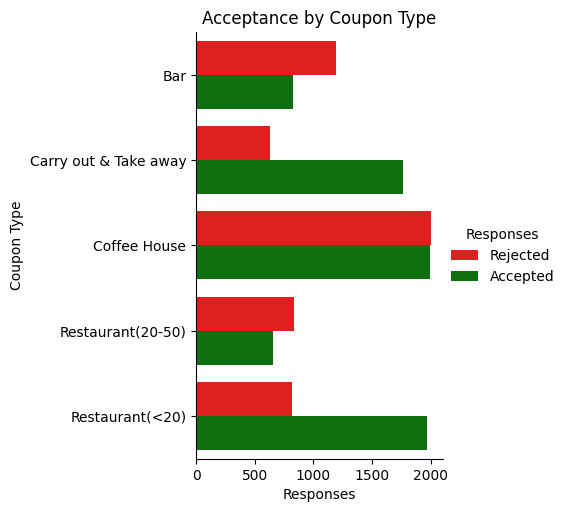

In [11]:
# Generate graph and prettify

plt.rcParams["figure.figsize"] = (7,5)

sns.catplot(data=coupon, kind='bar',
            y='coupon', x='count', hue='Responses',
            palette={'Rejected':'red', 'Accepted':'green'}
           )
plt.title('Acceptance by Coupon Type')
plt.xlabel('Responses')
plt.ylabel('Coupon Type')
plt.show()

### Use a histogram to visualize the temperature column.

**Strategy**

* No data prep needed - we can just graph it

<Axes: xlabel='temperature', ylabel='Count'>

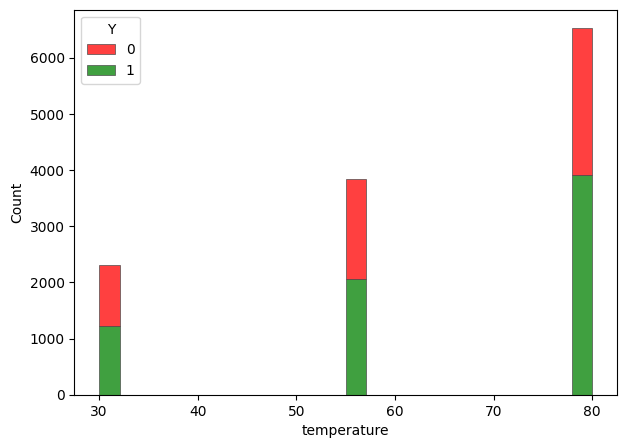

In [12]:
# No prep needed, just graph it

plt.rcParams["figure.figsize"] = (7,5)

sns.histplot(
    data=data,
    x='temperature', hue='Y',
    multiple='stack', #bins=50,
    edgecolor='.3', linewidth=.5,
    palette=['red','green'] #, alpha=0.5,
)

## Investigating the Bar Coupons

Now, we will lead you through an exploration of just the bar related coupons.  


#### Utility Function: Generate stacked-barplots for criteria-based queries - reused in multiple places

* This utility function is used to generate the Acceptance Stacked Bar graphs based on criteria queries for the various investigations
* Called multiple times to visualize the results of criteria-based queries

In [13]:
# graph it now

def graph_criteria_query_barchart(graph_df, label_x, label_y, label_t, png_out_filepath):
    """
    Generates a stacked bar graph for data in the following dictionary format:
    
        {0: {0: 1144, 1: 46},
         1: {0: 674, 1: 153},
         'criteria': {0: '3 or fewer', 1: 'More than 3'},
         'total': {0: 1818, 1: 199},
         'rate': {0: 37.07, 1: 76.88}}
    
    where
    
        0: Rejected coupons
        1: Accepted coupons
        criteria: Label for x-axis that was used to query the coupons data. Must be unique per row
        total: 0 + 1
        rate: Acceptance rate
        
    
    :param graph_df: DF in the above format
    :param label_x: x-axis label
    :param label_y: y-axis label
    :param label_t: title
    :param png_out_filepath: output filepath to save graph as a PNG
    """
    sns.set_theme(style='darkgrid', palette=None)

    fig, ax = plt.subplots(figsize=(9,5))

    # Start the bar plot using the totals in red
    bar_total = ax.bar(graph_df['criteria'], graph_df['total'], color = 'red')

    # Overlay with accepted as green
    bar_accepted = ax.bar(graph_df['criteria'], graph_df[1], color = 'green')

    # Adding the values from column '1' on the bars
    for i, bar in enumerate(bar_accepted):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x position
            bar.get_y() + height / 2,  # y position (middle of the bar)
            f'{graph_df["rate"][i]:.2f}%',  # text (the rate value)
            ha='center',  # horizontal alignment
            va='center',  # vertical alignment
            color='orange',  # text color
            fontsize=12  # text font size
        )

    # Create the legend
    topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')
    l = plt.legend([bottombar, topbar], ['Accepted', 'Rejected'], loc=0)
    #l.draw_frame(False)

    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.set_title(label_t)

    plt.savefig(png_out_filepath)

    plt.show()


### Create a new `DataFrame` that contains just the bar coupons.

**Strategy**

* Make a new copy of the 'curated' data from earlier called 'coupons_bar'
* Replace the NAN values with 'Missing' so we can track it and deal with it downstream if necessary
    * 21 rows are tagged with Bar Coupon type as 'Missing'

In [14]:
# Make a new copy of the "curated" data from earlier

coupons_bar = data.copy();
coupons_bar = coupons_bar[data.coupon == 'Bar']
coupons_bar.head(2)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
9,No Urgent Place,Kid(s),Sunny,80,10AM,Bar,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
13,Home,Alone,Sunny,55,6PM,Bar,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,1,0,1


In [15]:
# Replace the NAN values with 'Missing' so we can track it and deal with it downstream if necessary
coupons_bar.Bar = coupons_bar.Bar.fillna(value='Missing')
coupons_bar[['Bar']].value_counts()

Bar    
never      830
less1      570
1~3        397
4~8        150
gt8         49
Missing     21
Name: count, dtype: int64

In [16]:
print('Replaced coupons_bar[[\'Bar\']].isna() with \'Missing\': {} instances'
      .format(coupons_bar[['Bar']].value_counts()['Missing']))

Replaced coupons_bar[['Bar']].isna() with 'Missing': 21 instances


### What proportion of bar coupons were accepted?

**Strategy**

* Calcualte the Bar Coupon Acceptance Rate using coupons_bar.shape
    * _I'm not removing the 21 Missing bar coupon types as we are looking at overall acceptance rate across all bar coupons so they should be included the count_
* Visualize the data in a couple of different ways 
    * Visualization 1: Pie chart of overall Bar Coupon Acceptance Rate
    * Visualization 2: Bar graph of Bar Coupon Acceptance distribution


In [17]:
acceptance_rate_bar = (coupons_bar[coupons_bar['Y'] == 1].shape[0] / coupons_bar.shape[0]) * 100
print('Overall Bar Coupon Acceptance Rate: {:.2f}%'.format(acceptance_rate_bar))

Overall Bar Coupon Acceptance Rate: 41.00%


#### Visualization 1: Pie chart of the Overall Bar Coupon Acceptance Rate

**Strategy**
* Data Prep: Create acceptanece_rate_pie DF using groupby('Y').value_counts()
* Fix the labels and set the color appropriately as above

**Findings**
* The overall Bar Coupon Acceptance Rate as a Pie Graph

![](images/pie-acceptance-overall.png)


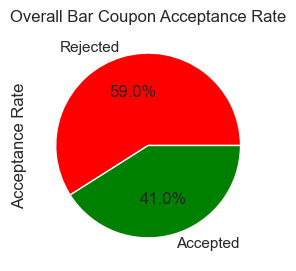

In [37]:
# Create the DF for the graph
acceptance_rate_pie = coupons_bar.groupby('Y')['Y'].value_counts().rename('Acceptance Rate').reset_index()

# Prettify graph
names = ('Rejected', 'Accepted')
colors = ('red', 'green')
plt.rcParams["figure.figsize"] = (3,3)
sns.set_theme(style='darkgrid', palette=None)

acceptance_rate_pie.plot.pie(y='Acceptance Rate',
                             autopct='%1.1f%%', 
                             labels=names,
                             colors=colors,
                             legend=False
                            )
plt.title('Overall Bar Coupon Acceptance Rate')

plt.savefig('images/pie-acceptance-overall.png')

#### Visualization 2: Bar graph of the Overall Bar Coupon Acceptance distribution

**Strategy**
* Data Prep
    * Create new DF with counts of each coupon type groupby('Bar').value_counts()
    * Create a pivot table with each row containing both acceptance and rejection per coupon type
    * Calculate totals and acceptance rate for each row (bucket)
    * Manually order the buckets so they x-axis appear 'natural' like a time-series
* Bar graph: ```Call graph_criteria_query_barchart()``` to graph the data

**Findings**
* Overall Coupon Accepted / Rejected as a stacked-bar graph showing the distribution per Bar Coupon Type

![](images/bar-acceptance-overall.png)


In [19]:
# Bar acceptance buckets by count
bar_count = (coupons_bar
             .groupby('Bar')['Y']
             .value_counts()
             .reset_index()
)
#bar_count

In [20]:
bar_p = bar_count.pivot(index='Bar', columns='Y', values='count').reset_index()
bar_p['total'] = bar_p[0] + bar_p[1]
bar_p['rate'] = (bar_p[1] / bar_p['total']).mul(100).round(2)
#bar_p

In [21]:
# Manually sort based on frequency of visiting a bar
col_order = [2, 5, 4, 0, 1, 3]
bar_p = bar_p.reindex(col_order)
#bar_p

In [22]:
# re-foramt data to send to graph_criteria_query_barchart() function
# 1. rename Bar column to criteria
# 2. Remove the Y column index

bar_p = bar_p.rename(columns={'Bar':'criteria'})

bar_temp_df = pd.DataFrame(bar_p.to_numpy(), 
                           columns=['criteria', 0, 1, 'total', 'rate'])
bar_temp_df

,criteria,0,1,total,rate
0,Missing,13,8,21,38.1
1,never,674,156,830,18.8
2,less1,317,253,570,44.39
3,1~3,140,257,397,64.74
4,4~8,33,117,150,78.0
5,gt8,13,36,49,73.47


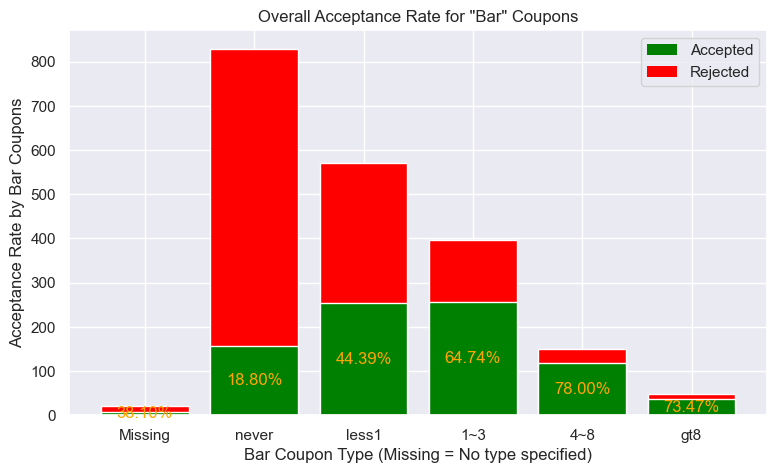

In [23]:
# Grapht it!
label_x='Bar Coupon Type (Missing = No type specified)'
label_y='Acceptance Rate by Bar Coupons'
label_t='Overall Acceptance Rate for "Bar" Coupons'
outfile='images/bar-acceptance-overall.png'
graph_criteria_query_barchart(bar_temp_df, label_x, label_y, label_t, outfile)

### Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.

**Strategy**

* Criteria: Visit bar 3 or fewer times a month
* Data Preparation
    * Inspect Bar column
    * Define list containing the list of Bar elements that meet the 3 or fewer criteria: 
    ```
    bar_3_or_fewer = ['Missing','never', 'less1', '1~3']
    ```
* Run criteria query for both ```in @bar_3_or_fewer``` and ```not in @bar_3_or_fewer``` cases
* Load the results into DF for graphing and call graph_criteria_query_barchart() function

**Findings**

1. Acceptance rate for the less frequent visitors was much lower (37.07%) compared to the "regulars" who accepted the coupons 76.88%
1. The results were as expected - "regulars" were almost twice as likely to redeem the coupons

![](images/bar-visit-3-or-more.png)

In [24]:
# Criteria for the visit frequency
bar_3_or_fewer = ['Missing','never', 'less1', '1~3']

graph_data = []

# Get the stats for IN @bar_3_or_fewer
graph_row = (coupons_bar.query('Bar in @bar_3_or_fewer')
             .groupby('Y')['Y']
             .value_counts()
)
graph_row[2] = '3 or fewer'
graph_data.append(graph_row.values)
#graph_data

In [25]:
# Get the stats for NOT IN @bar_3_or_fewer
graph_row = (coupons_bar.query('Bar not in @bar_3_or_fewer')
             .groupby('Y')['Y']
             .value_counts()
)
graph_row[2] = 'More than 3'
graph_data.append(graph_row.values)
#graph_data

In [26]:
# Load the graph data into DF for graphing
graph_df = pd.DataFrame(graph_data)

# Calculate totals and acceptance rate
graph_df['total'] = graph_df[0] + graph_df[1]
graph_df['rate'] = (graph_df[1] / graph_df['total']).mul(100).round(2)

# Rename the criteria column
graph_df = graph_df.rename(columns={2:'criteria'})
graph_df

,0,1,criteria,total,rate
0,1144,674,3 or fewer,1818,37.07
1,46,153,More than 3,199,76.88


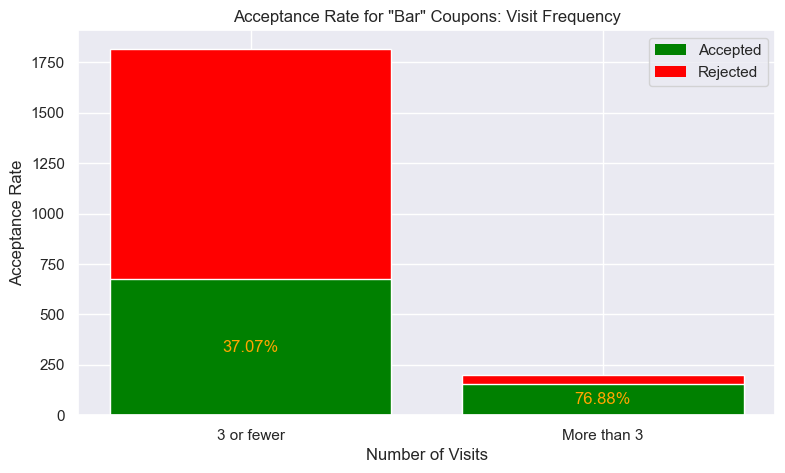

In [27]:
# Grapht it!
label_x='Number of Visits'
label_y='Acceptance Rate'
label_t='Acceptance Rate for "Bar" Coupons: Visit Frequency'
outfile='images/bar-visit-3-or-more.png'
graph_criteria_query_barchart(graph_df, label_x, label_y, label_t, outfile)

### Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?

**Strategy**

* Criteria: Visit bar more than once and over 25 yrs old
* Data Preparation
    * Inspect the age column for clean data
        * Create a new DF for our query - copy needed because we need to normalize the ages and don't want to mess up the clean data
        * Convert age=below21 to 20 and age=50plus to 51 - good enough for age > 25 criteria
        * Convert 'age' to ints
    * Define list containing the list of Bar elements that meet the 3 or fewer criteria: 
        ```
        bar_1_or_more = ['1~3','4~8', 'gt8']
        ```
* Run criteria query
* Load the results into DF for graphing and call graph_criteria_query_barchart() function

**Findings**

1. Acceptance rate for those who visit a bar more than once a month and are over 25yrs old was higher (69.52%) compared to the rest of the population (39.33%)
1. The results were as expected - "regulars" of legal age were almost twice as likely to redeem the coupons

![](images/bar-25plus-frequent.png)

In [28]:
coupons_bar.age.value_counts()

age
21         417
26         395
31         339
50plus     283
36         209
41         178
46         109
below21     87
Name: count, dtype: int64

In [29]:
# Create a new DF for our query - copy needed because we need to normalize the ages to ints
temp_coupons_bar = coupons_bar.copy()

# convert age=below21 to 20 and age=50plus to 51 - good enough for age > 25 criteria
temp_coupons_bar['age'] = temp_coupons_bar['age'].replace({'below21': 20, '50plus': 51})
temp_coupons_bar['age'] = temp_coupons_bar['age'].astype(int)

#temp_coupons_bar.age.value_counts()

In [30]:
# criteria for visit frequecy
bar_1_or_more = ['1~3','4~8', 'gt8']
criteria = ''

graph_data = []

# Get the stats for IN @bar_3_or_fewer
graph_row = (temp_coupons_bar.query('(Bar in @bar_1_or_more and age > 25)')
             .groupby('Y')['Y']
             .value_counts()
)
graph_row[2] = 'Visits > 1 and age > 25'
graph_data.append(graph_row.values)

# Get the stats for NOTIN @bar_3_or_fewer
graph_row = (temp_coupons_bar.query('Bar not in @bar_1_or_more and age <= 25')
             .groupby('Y')['Y']
             .value_counts()
)
graph_row[2] = 'NOT (Visits > 1 and age > 25)'
graph_data.append(graph_row.values)
#graph_data

In [31]:
# Load the graph data into DF for graphing
graph_df = pd.DataFrame(graph_data)

# Calculate totals and acceptance rate
graph_df['total'] = graph_df[0] + graph_df[1]
graph_df['rate'] = (graph_df[1] / graph_df['total']).mul(100).round(2)

# Rename the criteria column
graph_df = graph_df.rename(columns={2:'criteria'})
graph_df

,0,1,criteria,total,rate
0,128,292,Visits > 1 and age > 25,420,69.52
1,199,129,NOT (Visits > 1 and age > 25),328,39.33


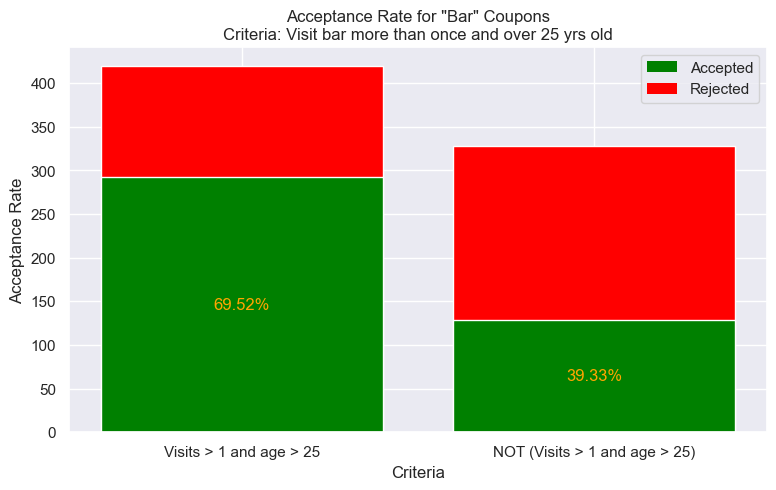

In [32]:
# Grapht it!
label_x='Criteria'
label_y='Acceptance Rate'
label_t='Acceptance Rate for "Bar" Coupons\nCriteria: Visit bar more than once and over 25 yrs old'
outfile='images/bar-no-kids.png'
graph_criteria_query_barchart(graph_df, label_x, label_y, label_t, outfile)

### Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry. 


**Strategy**

* Criteria: Visits > 1 and passengers != 'Kid(s)' and occupations != 'Farming Fishing & Forestry'
* Data Preparation
    * Inspect the passenger column for clean data - looks good!
    * Inspect the occupation column for clean data - looks good
        * Create a new DF for our query - copy needed because we need to normalize the ages and don't want to mess up the clean data
        * Convert age=below21 to 20 and age=50plus to 51 - good enough for age > 25 criteria
        * Convert 'age' to ints
    * Define list containing the list of Bar elements that meet the 3 or fewer criteria: 
        ```
        bar_1_or_more = ['1~3','4~8', 'gt8']
        passengers = ['Kid(s)']
        occ_farming = ['Farming Fishing & Forestry']
        ```
* Run criteria query
* Load the results into DF for graphing and call graph_criteria_query_barchart() function

**Findings**

1. Criteria query SQL
```
criteria='((Bar in @bar_1_or_more) and (passanger not in @passengers) and (occupation not in @occ_farming))'
criteria_not='((Bar not in @bar_1_or_more) and (passanger in @passengers) and (occupation in @occ_farming))'
```

1. Acceptance rate for those who meet the criteria was higher (71.32%) compared to the rest of the population (33.33%)
1. As expected, since the contra-group included children as passengers, there were only 3 total samples
1. The overall results were as expected - "regulars" without child passengers redeemed the coupons in much higher numbers: 393 vs 1!
![](images/bar-no-kids.png)

In [38]:
#coupons_bar.passanger.value_counts()
#coupons_bar.occupation.value_counts()

In [39]:
# criteria: Visits > 1 and passengers != 'Kid(s)' and occupations != 'Farming Fishing & Forestry'
bar_1_or_more = ['1~3','4~8', 'gt8']
passengers = ['Kid(s)']
occ_farming = ['Farming Fishing & Forestry']

graph_data = []

criteria='((Bar in @bar_1_or_more) and (passanger not in @passengers) and (occupation not in @occ_farming))'
criteria_not='((Bar not in @bar_1_or_more) and (passanger in @passengers) and (occupation in @occ_farming))'
# Get the stats for IN criteria
graph_row = (temp_coupons_bar.query(criteria)
             .groupby('Y')['Y']
             .value_counts()
)
graph_row[2] = 'Visits > 1, not a farmer, no kids'
graph_data.append(graph_row.values)

# Get the stats for NOT IN criteria
graph_row = (temp_coupons_bar.query(criteria_not)
             .groupby('Y')['Y']
             .value_counts()
)
graph_row[2] = 'NOT (Visits > 1, not a farmer, no kids)'
graph_data.append(graph_row.values)
#graph_data

In [40]:
# Load the graph data into DF for graphing
graph_df = pd.DataFrame(graph_data)

# Calculate totals and acceptance rate
graph_df['total'] = graph_df[0] + graph_df[1]
graph_df['rate'] = (graph_df[1] / graph_df['total']).mul(100).round(2)

# Rename the criteria column
graph_df = graph_df.rename(columns={2:'criteria'})
graph_df

,0,1,criteria,total,rate
0,158,393,"Visits > 1, not a farmer, no kids",551,71.32
1,2,1,"NOT (Visits > 1, not a farmer, no kids)",3,33.33


**Findings**

1. Criteria query SQL
```
criteria='((Bar in @bar_1_or_more) and (passanger not in @passengers) and (occupation not in @occ_farming))'
criteria_not='((Bar not in @bar_1_or_more) and (passanger in @passengers) and (occupation in @occ_farming))'
```

1. Acceptance rate for those who meet the criteria was higher (71.32%) compared to the rest of the population (33.33%)
1. As expected, since the contra-group included children as passengers, there were only 3 total samples
1. The overall results were as expected - "regulars" without child passengers redeemed the coupons in much higher numbers: 393 vs 1!

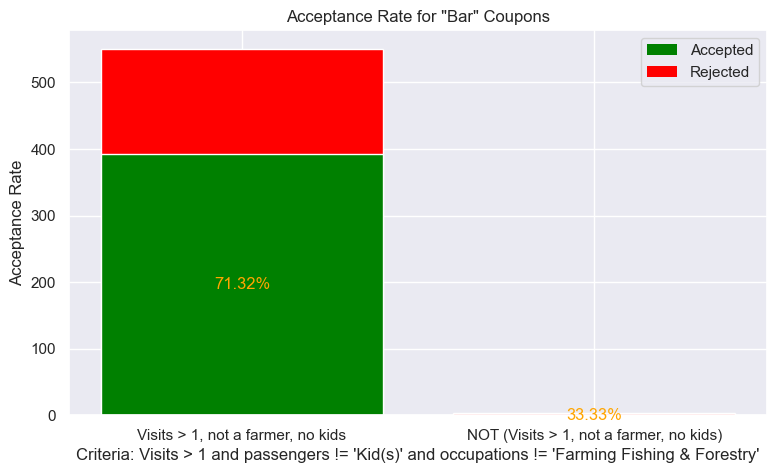

In [41]:
# Grapht it!
label_x="Criteria: Visits > 1 and passengers != 'Kid(s)' and occupations != 'Farming Fishing & Forestry'"
label_y='Acceptance Rate'
label_t='Acceptance Rate for "Bar" Coupons'
outfile='images/bar-no-kids.png'
graph_criteria_query_barchart(graph_df, label_x, label_y, label_t, outfile)

### Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K. 



###  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

## Independent Investigation

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.  